# Impact of soap - Reproductivity of the field maps acquisitions

In this notebook, we test the impact of small amounts of soap on the susceptibility difference between material and external solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cmath
import nibabel as nib
import cv2
from sklearn.linear_model import LinearRegression 
import scipy
import scipy.io
from skimage.transform import rescale as resc
from skimage.transform import downscale_local_mean
import plotly.graph_objects as go
from scipy.io import savemat
from scipy.ndimage import gaussian_filter


In [2]:
### parameters and constants
TE1=3.06*0.001 #s
TE2=4.08*0.001 #s
delta_TE=TE2-TE1
gamma = 2.675221900e8 # /s/T

## I. Loading the data - Determination of the centers - Redefining the FOV

In [3]:
def mask(path_mag1, material, tresh, plot=True, slice=71):
    '''
    Return a mask with 0 if inside the ball and 1 outside

    Parameters
    ----------
    path_mag1 : str
        path to the magnitude 1 of the material.
    material : str
        description of the material.
    tresh : float
        magnetude treshold of the mask.
    plot : bool, optional
        if true, plot a slice of the magnitude and of the mask. The default is True.
    slice : int, optional
        the slice to plot. The default is 71.

    Returns
    -------
    mask : numpy.ndarray
        mask of the ball.

    '''
    ######## magnitude #############
    mag1 = nib.load(path_mag1)
    data_mag1=mag1.get_fdata() #extract matrix with values
    
    mask = data_mag1 > tresh #return array of booleens
    
    
    #plot the selected slice 
    if plot==True:
        plt.figure(figsize=(8,5))
        plt.subplot(1,2,1)
        plt.imshow(data_mag1[:,:,slice])
        plt.colorbar()
        plt.title(f'Magnitude_1 of {material}')
    
        plt.subplot(1,2,2)
        plt.imshow(mask[:, :, slice])
        plt.colorbar()
        plt.title(f'mask of {material}')
    
        plt.tight_layout()
    #return matrix of delta_B
    return mask

In [4]:
def rescale(path_mag1, path_phase, material, deltaTE=delta_TE, slice=80, masking=True):
    '''
    Rescale the acquired phase difference to a field map in Hz.
    
    Rescale from the phase difference in 2^13 bits to a field map in Hz, and plot the magnitude, phase difference and field map.
    If masking = True then put values inside the compound at zero.


    Parameters
    ----------
    path_mag1 : str
        path to the first magnitude.
    path_phase : str
        path to the phase difference.
    material : str
        description of the compound.
    deltaTE : float
        TE2-TE1.
    slice : int, optional
        Slice to plot. The default is 80.
    masking : bool, optional
        apply the mask of the magnitude to the field map. The default is True.

    Returns
    -------
    data_phase : numpy.ndarray
        rescaled field map in Hz.

    '''
    ######## magnitude #############
    data_mag1=nib.load(path_mag1).get_fdata() #extract matrix with values of magnitude 1
    
    #plot the selected slice of the magnitude
    plt.figure('f{material}', figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(data_mag1[:,:,slice])
    plt.colorbar()
    plt.title(f'Magnitude_1 of {material}')
    
    
    ########### phase difference and field map ############
    data_phase = nib.load(path_phase).get_fdata() #extract matrix with values
    
    #rescaling:a
    data_phase *= np.pi/4096 #set the phase between -pi and pi
    data_phase /= (deltaTE*2*np.pi) #in Hz
    #data_phase /= gamma # in T
    
    # apply the mask if needed
    if masking==True:
        maske=mask(path_mag1, material, 400, plot=False, slice=slice)
        data_phase *= maske
    
    
    #plot the selected slice of field map
    plt.subplot(1,2,2)
    plt.imshow(data_phase[:,:,slice])
    plt.colorbar()
    plt.title(f'Field map (Hz) of {material}')
    plt.show()
    
    plt.tight_layout()
    
    #return matrix of delta_B
    return data_phase #return field map

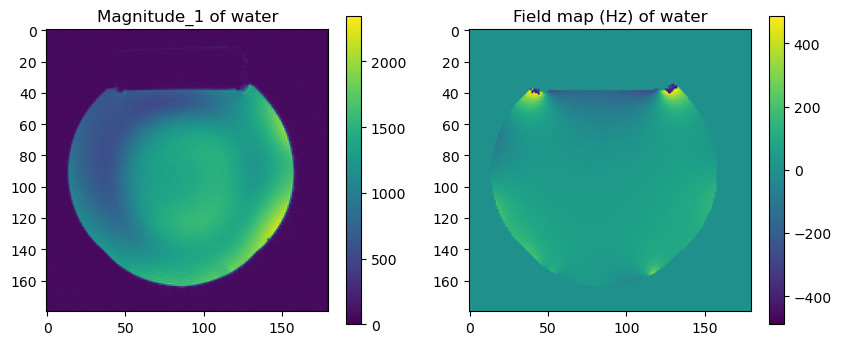

<Figure size 640x480 with 0 Axes>

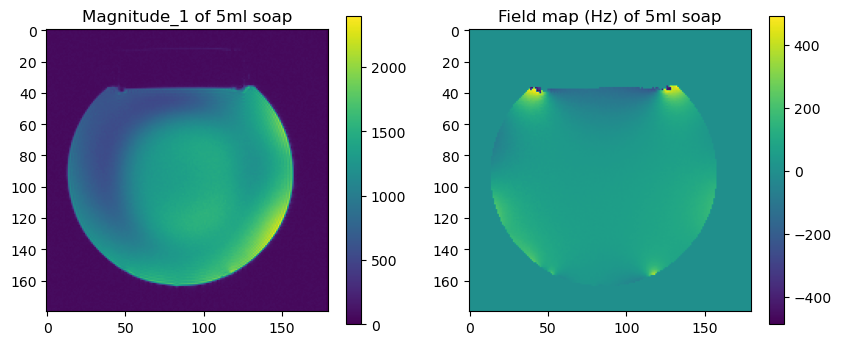

<Figure size 640x480 with 0 Axes>

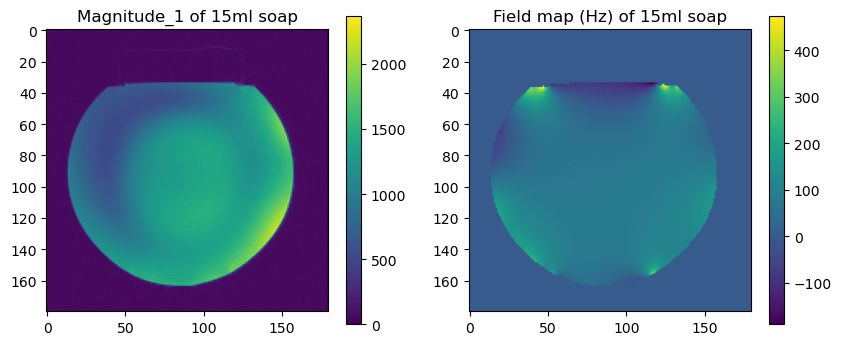

<Figure size 640x480 with 0 Axes>

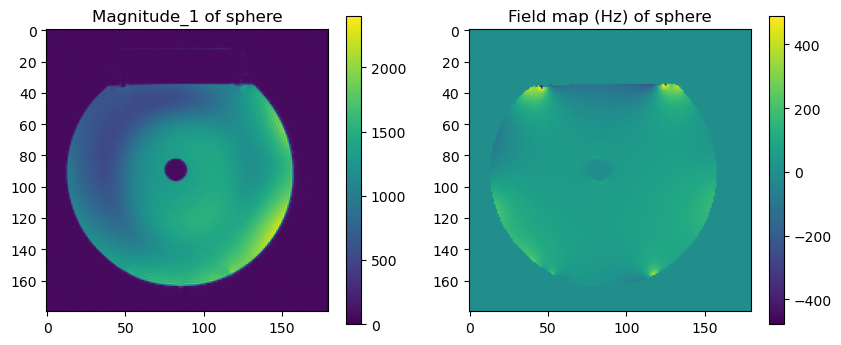

<Figure size 640x480 with 0 Axes>

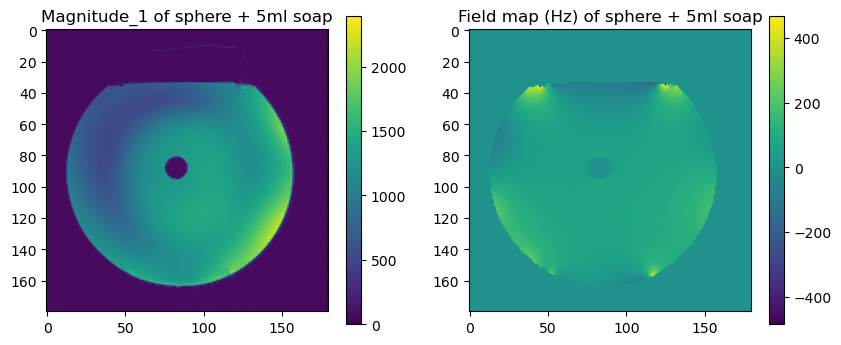

<Figure size 640x480 with 0 Axes>

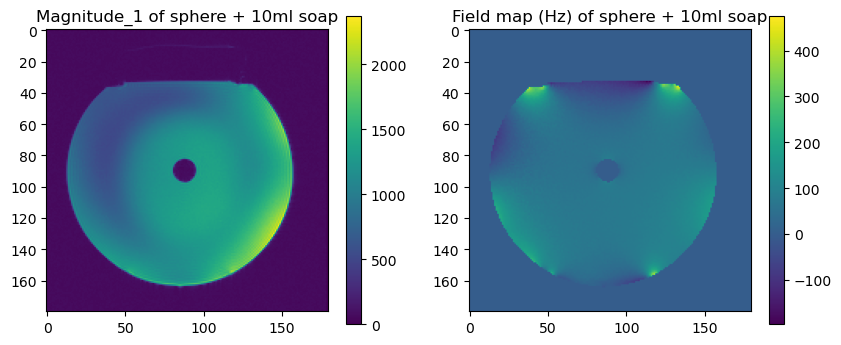

<Figure size 640x480 with 0 Axes>

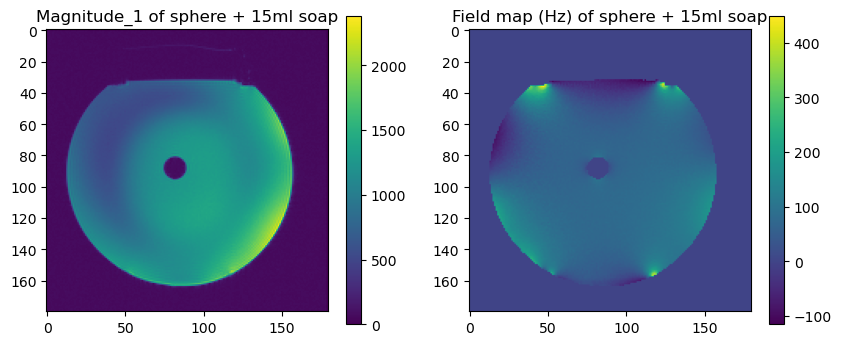

<Figure size 640x480 with 0 Axes>

In [5]:
# water + salt
path_mag1_water = r"data_sphere_and_water\FM_1_0MM_WATER_0002\FM_1_0MM_WATER_0002_fm_1.0mm_water_20221118144958_2_e1.nii.gz"
path_phase_water = r"data_sphere_and_water\FM_1_0MM_WATER_0003\FM_1_0MM_WATER_0003_fm_1.0mm_water_20221118144958_3_e2_ph.nii.gz"
delta_B_water = rescale(path_mag1_water, path_phase_water, "water", delta_TE, masking=True)

#water + salt + 5ml soap
path_mag1_water_soap5ml = r"data_sphere_and_water\FM_1_0MM_WATER_SOAP5ML_0008\FM_1_0MM_WATER_SOAP5ML_0008_fm_1.0mm_water_soap5ml_20221118144958_8_e1.nii.gz"
path_phase_water_soap5ml = r"data_sphere_and_water\FM_1_0MM_WATER_SOAP5ML_0009\FM_1_0MM_WATER_SOAP5ML_0009_fm_1.0mm_water_soap5ml_20221118144958_9_e2_ph.nii.gz"
delta_B_water_soap5ml = rescale(path_mag1_water_soap5ml, path_phase_water_soap5ml, "5ml soap", delta_TE, masking=True)

#water + salt + 15ml soap
path_mag1_water_soap15ml = r"data_sphere_and_water\FM_1_0MM_WATER_SOAP15ML_0021\FM_1_0MM_WATER_SOAP15ML_0021_fm_1.0mm_water_soap15ml_20221118144958_21_e1.nii.gz"
path_phase_water_soap15ml = r"data_sphere_and_water\FM_1_0MM_WATER_SOAP15ML_0022\FM_1_0MM_WATER_SOAP15ML_0022_fm_1.0mm_water_soap15ml_20221118144958_22_e2_ph.nii.gz"
delta_B_water_soap15ml = rescale(path_mag1_water_soap15ml, path_phase_water_soap15ml, "15ml soap", delta_TE, masking=True)

#sphere + water + salt 
path_mag1_sphere = r"data_sphere_and_water\FM_1_0MM_SPHERE_0005\FM_1_0MM_SPHERE_0005_fm_1.0mm_sphere_20221118144958_5_e1.nii.gz" 
path_phase_sphere = r"data_sphere_and_water\FM_1_0MM_SPHERE_0006\FM_1_0MM_SPHERE_0006_fm_1.0mm_sphere_20221118144958_6_e2_ph.nii.gz"
delta_B_sphere = rescale(path_mag1_sphere, path_phase_sphere, "sphere", delta_TE, masking=True)

#sphere + water + salt + 5ml soap
path_mag1_sphere_soap5ml = r"data_sphere_and_water\FM_1_0MM_SPHERE_SOAP5ML_0011\FM_1_0MM_SPHERE_SOAP5ML_0011_fm_1.0mm_sphere_soap5ml_20221118144958_11_e1.nii.gz"
path_phase_sphere_soap5ml = r"data_sphere_and_water\FM_1_0MM_SPHERE_SOAP5ML_0012\FM_1_0MM_SPHERE_SOAP5ML_0012_fm_1.0mm_sphere_soap5ml_20221118144958_12_e2_ph.nii.gz"
delta_B_sphere_soap5ml = rescale(path_mag1_sphere_soap5ml, path_phase_sphere_soap5ml, "sphere + 5ml soap", delta_TE, masking=True)

#sphere + water + salt + 10ml soap
path_mag1_sphere_soap10ml = r"data_sphere_and_water\FM_1_0MM_SPHERE_SOAP10ML_0014\FM_1_0MM_SPHERE_SOAP10ML_0014_fm_1.0mm_sphere_soap10ml_20221118144958_14_e1.nii.gz"
path_phase_sphere_soap10ml = r"data_sphere_and_water\FM_1_0MM_SPHERE_SOAP10ML_0015\FM_1_0MM_SPHERE_SOAP10ML_0015_fm_1.0mm_sphere_soap10ml_20221118144958_15_e2_ph.nii.gz"
delta_B_sphere_soap10ml = rescale(path_mag1_sphere_soap10ml, path_phase_sphere_soap10ml, "sphere + 10ml soap", delta_TE, masking=True)

#sphere + water + salt + 15ml soap
path_mag1_sphere_soap15ml = r"data_sphere_and_water\FM_1_0MM_SPHERE_SOAP15ML_0018\FM_1_0MM_SPHERE_SOAP15ML_0018_fm_1.0mm_sphere_soap15ml_20221118144958_18_e1.nii.gz"
path_phase_sphere_soap15ml = r"data_sphere_and_water\FM_1_0MM_SPHERE_SOAP15ML_0019\FM_1_0MM_SPHERE_SOAP15ML_0019_fm_1.0mm_sphere_soap15ml_20221118144958_19_e2_ph.nii.gz"
delta_B_sphere_soap15ml = rescale(path_mag1_sphere_soap15ml, path_phase_sphere_soap15ml, "sphere + 15ml soap", delta_TE, masking=True)

Visual comparison of the field maps with the spheres and different concentrations of soap:

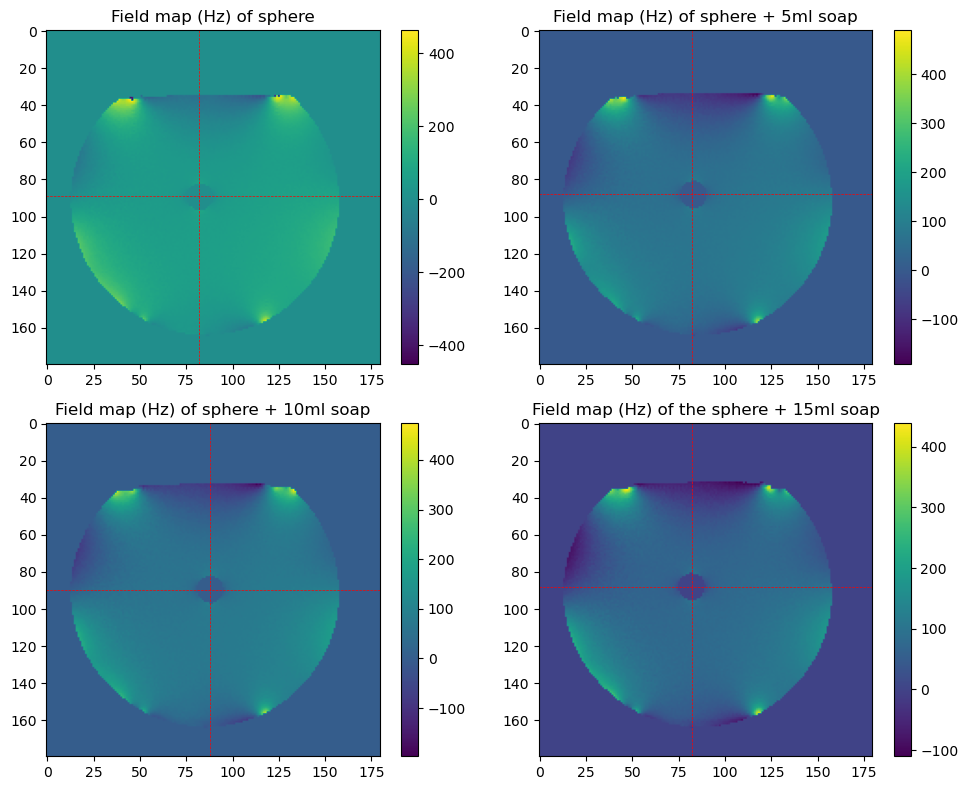

In [6]:
plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.imshow(delta_B_sphere[:,:,79])
plt.colorbar()
plt.axvline(x=82,color='r',linestyle='--', linewidth=0.5) #to find the center of the ball
plt.axhline(y=89,color='r',linestyle='--', linewidth=0.5) #to find the center of the ball
plt.title(f'Field map (Hz) of sphere')

plt.subplot(2,2,2)
plt.imshow(delta_B_sphere_soap5ml[:,:,81])
plt.axvline(x=82,color='r',linestyle='--', linewidth=0.5)
plt.axhline(y=88,color='r',linestyle='--', linewidth=0.5) #to find the center of the ball
plt.colorbar()
plt.title(f'Field map (Hz) of sphere + 5ml soap')

plt.subplot(2,2,3)
plt.imshow(delta_B_sphere_soap10ml[:,:,80])
plt.axvline(x=88,color='r',linestyle='--', linewidth=0.5)
plt.axhline(y=90,color='r',linestyle='--', linewidth=0.5) #to find the center of the ball
plt.colorbar()
plt.title(f'Field map (Hz) of sphere + 10ml soap')

plt.subplot(2,2,4)
plt.imshow(delta_B_sphere_soap15ml[:,:,79])
plt.axvline(x=82,color='r',linestyle='--', linewidth=0.5)
plt.axhline(y=88,color='r',linestyle='--', linewidth=0.5) #to find the center of the ball
plt.colorbar()
plt.title(f'Field map (Hz) of the sphere + 15ml soap')
plt.tight_layout()
plt.show()

centers of the balls:

In [7]:
##############################################################################""""""

x_sphere, y_sphere, z_sphere = 82,89,79
x_sphere_soap5ml, y_sphere_soap5ml, z_sphere_soap5ml = 82,88,81
x_sphere_soap10ml, y_sphere_soap10ml, z_sphere_soap10ml = 88,90,80
x_sphere_soap15ml, y_sphere_soap15ml, z_sphere_soap15ml = 82,88,79

dx, dy, dz = 12,12,12
#################################################################################

#### Line plots in the x, y and z directions

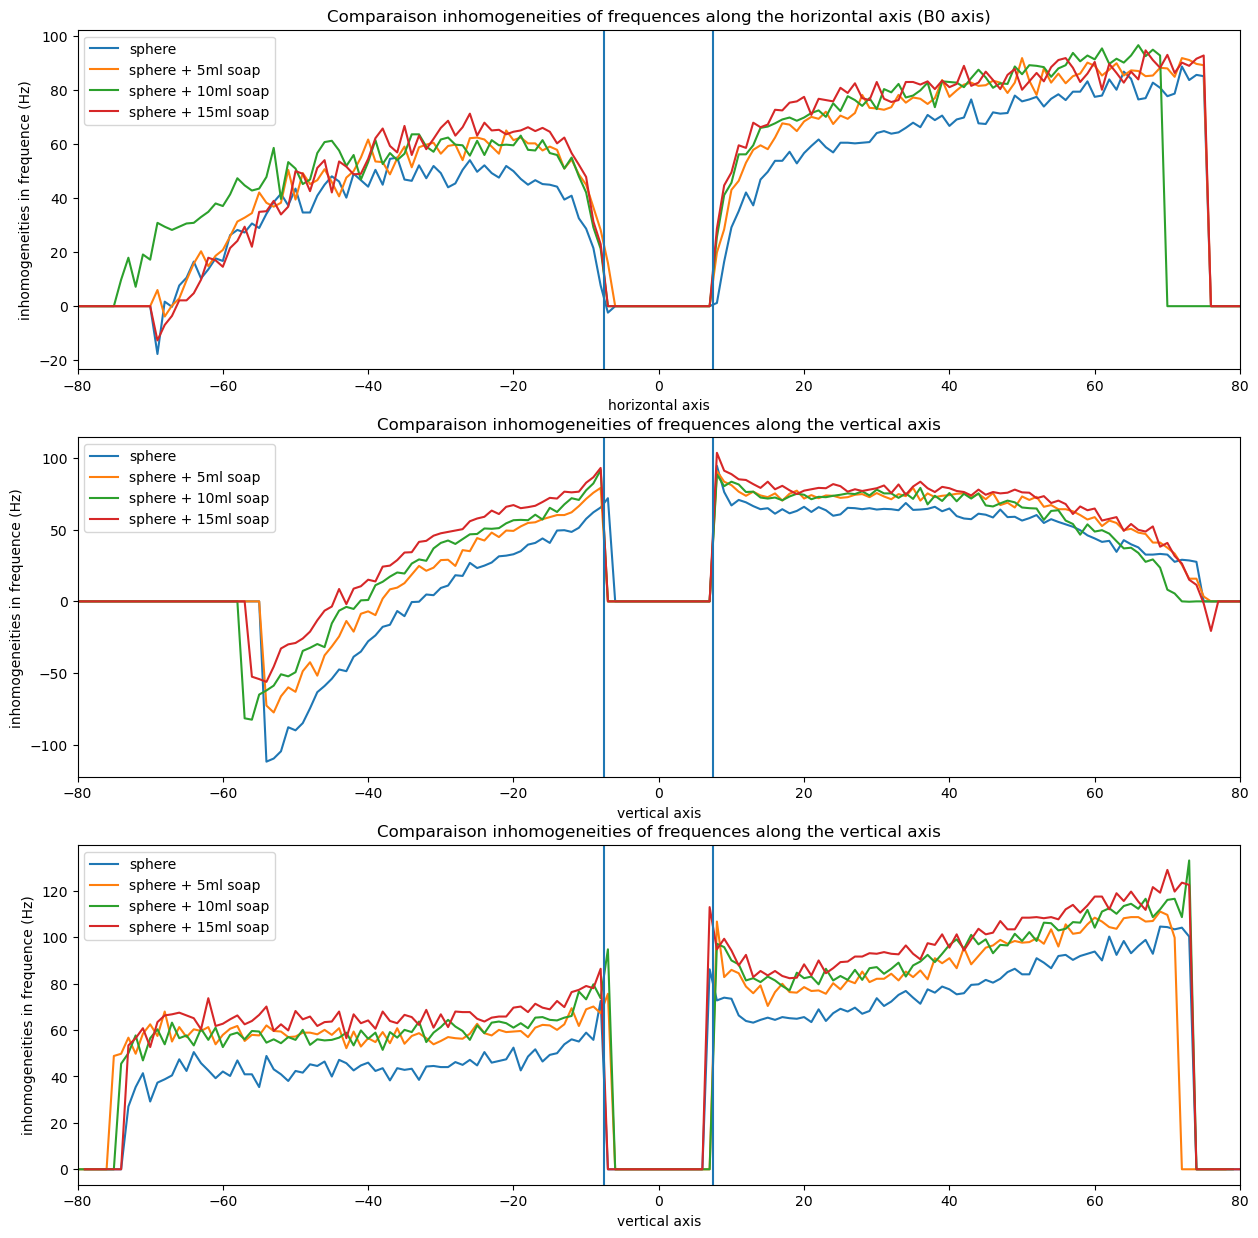

<Figure size 640x480 with 0 Axes>

In [8]:
##### plot lineplot axe horizontal
freq_sphere_x = (delta_B_sphere[y_sphere, :, z_sphere])
freq_sphere_soap5ml_x = (delta_B_sphere_soap5ml[y_sphere_soap5ml, :, z_sphere_soap5ml])
freq_sphere_soap10ml_x = (delta_B_sphere_soap10ml[y_sphere_soap10ml, :, z_sphere_soap10ml])
freq_sphere_soap15ml_x = (delta_B_sphere_soap15ml[y_sphere_soap15ml, :, z_sphere_soap15ml])

abscisse_sphere_x = [i-x_sphere for i in range(180)] #recenter the ball at zero
abscisse_sphere_soap5ml_x = [i-x_sphere_soap5ml for i in range(180)]
abscisse_sphere_soap10ml_x = [i-x_sphere_soap10ml for i in range(180)]
abscisse_sphere_soap15ml_x = [i-x_sphere_soap15ml for i in range(np.shape(delta_B_sphere_soap15ml)[0])]


plt.figure(figsize=(15,15))
plt.subplot(3,1,1)
plt.plot(abscisse_sphere_x, freq_sphere_x, label='sphere')
plt.plot(abscisse_sphere_soap5ml_x, freq_sphere_soap5ml_x, label='sphere + 5ml soap')
plt.plot(abscisse_sphere_soap10ml_x, freq_sphere_soap10ml_x, label='sphere + 10ml soap')
plt.plot(abscisse_sphere_soap15ml_x, freq_sphere_soap15ml_x, label='sphere + 15ml soap')
plt.title('Comparaison inhomogeneities of frequences along the horizontal axis (B0 axis)')
plt.xlabel('horizontal axis')
plt.ylabel('inhomogeneities in frequence (Hz)')
plt.xlim(-80,80)
plt.legend()
plt.axvline(x=7.5)
plt.axvline(x=-7.5)

##### plot lineplot axe vertical
freq_sphere_y = (delta_B_sphere[:, x_sphere, z_sphere])
freq_sphere_soap5ml_y = (delta_B_sphere_soap5ml[:, x_sphere_soap5ml, z_sphere_soap5ml])
freq_sphere_soap10ml_y = (delta_B_sphere_soap10ml[:, x_sphere_soap10ml, z_sphere_soap10ml])
freq_sphere_soap15ml_y = (delta_B_sphere_soap15ml[:, x_sphere_soap15ml, z_sphere_soap15ml])


abscisse_sphere_y = [i-y_sphere for i in range(180)] #recenter the ball at zero
abscisse_sphere_soap5ml_y = [i-y_sphere_soap5ml for i in range(180)]
abscisse_sphere_soap10ml_y = [i-y_sphere_soap10ml for i in range(180)]
abscisse_sphere_soap15ml_y = [i-y_sphere_soap15ml for i in range(np.shape(delta_B_sphere_soap15ml)[1])]


plt.subplot(3,1,2)
plt.plot(abscisse_sphere_y, freq_sphere_y, label='sphere')
plt.plot(abscisse_sphere_soap5ml_y, freq_sphere_soap5ml_y, label='sphere + 5ml soap')
plt.plot(abscisse_sphere_soap10ml_y, freq_sphere_soap10ml_y, label='sphere + 10ml soap')
plt.plot(abscisse_sphere_soap15ml_y, freq_sphere_soap15ml_y, label='sphere + 15ml soap')
plt.title('Comparaison inhomogeneities of frequences along the vertical axis')
plt.xlabel('vertical axis')
plt.ylabel('inhomogeneities in frequence (Hz)')
plt.xlim(-80,80)
plt.legend()
plt.axvline(x=7.5)
plt.axvline(x=-7.5)


##### plot lineplot axe profondeur
freq_sphere_z = (delta_B_sphere[y_sphere, x_sphere, :])
freq_sphere_soap5ml_z = (delta_B_sphere_soap5ml[y_sphere_soap5ml, x_sphere_soap5ml, :])
freq_sphere_soap10ml_z = (delta_B_sphere_soap10ml[y_sphere_soap10ml, x_sphere_soap10ml, :])
freq_sphere_soap15ml_z = (delta_B_sphere_soap15ml[y_sphere_soap15ml, x_sphere_soap15ml, :])



abscisse_sphere_z = [i-z_sphere for i in range(np.shape(delta_B_sphere_soap15ml)[2])] #recenter the ball at zero
abscisse_sphere_soap5ml_z = [i-z_sphere_soap5ml for i in range(np.shape(delta_B_sphere_soap15ml)[2])]
abscisse_sphere_soap10ml_z = [i-z_sphere_soap10ml for i in range(np.shape(delta_B_sphere_soap15ml)[2])]
abscisse_sphere_soap15ml_z = [i-z_sphere_soap15ml for i in range(np.shape(delta_B_sphere_soap15ml)[2])]


plt.subplot(3,1,3)
plt.plot(abscisse_sphere_z, freq_sphere_z, label='sphere')
plt.plot(abscisse_sphere_soap5ml_z, freq_sphere_soap5ml_z, label='sphere + 5ml soap')
plt.plot(abscisse_sphere_soap10ml_z, freq_sphere_soap10ml_z, label='sphere + 10ml soap')
plt.plot(abscisse_sphere_soap15ml_z, freq_sphere_soap15ml_z, label='sphere + 15ml soap')
plt.title('Comparaison inhomogeneities of frequences along the vertical axis')
plt.xlabel('vertical axis')
plt.ylabel('inhomogeneities in frequence (Hz)')
plt.axvline(x=7.5)
plt.axvline(x=-7.5)

plt.xlim(-80,80)
plt.legend()

plt.show()
plt.tight_layout()

correction of the background field

C:\Users\b\AppData\Local\Temp\ipykernel_16064\2936715788.py:23: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar()
C:\Users\b\AppData\Local\Temp\ipykernel_16064\2936715788.py:26: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar()
C:\Users\b\AppData\Local\Temp\ipykernel_16064\2936715788.py:29: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar()
C:\Users\b\AppDa

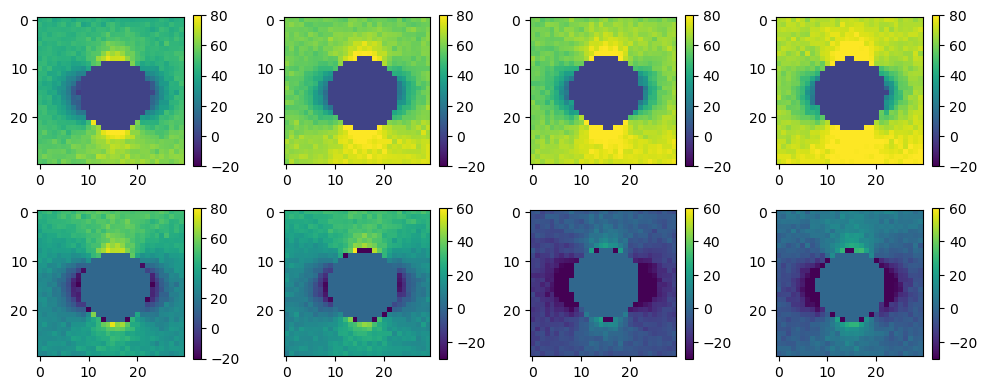

In [9]:
## if correction of the background:
fm_sphere = (delta_B_sphere - gaussian_filter(delta_B_water, sigma=2))*mask(path_mag1_sphere, '', tresh=200, plot=False, slice=71)
fm_soap5ml = (delta_B_sphere_soap5ml - gaussian_filter(delta_B_water_soap5ml, sigma=2))*mask(path_mag1_sphere_soap5ml, '', tresh=200, plot=False, slice=71)
fm_soap10ml = (delta_B_sphere_soap10ml - gaussian_filter(delta_B_water_soap15ml, sigma=2))*mask(path_mag1_sphere_soap10ml, '', tresh=200, plot=False, slice=71) 
fm_soap15ml = (delta_B_sphere_soap15ml - gaussian_filter(delta_B_water_soap15ml, sigma=2))*mask(path_mag1_sphere_soap15ml, '', tresh=200, plot=False, slice=71)

# ## if no correction
# fm_sphere = delta_B_sphere 
# fm_soap5ml = delta_B_sphere_soap5ml 
# fm_soap10ml =delta_B_sphere_soap10ml  
# fm_soap15ml = delta_B_sphere_soap15ml 



plt.figure(figsize=(10,4))
plt.subplot(2,4,1)
plt.imshow(delta_B_sphere[y_sphere-15:y_sphere+15,x_sphere-15:x_sphere+15,z_sphere], vmin=-20, vmax=80)
plt.colorbar()
plt.subplot(2,4,2)
plt.imshow(delta_B_sphere_soap5ml[y_sphere_soap5ml-15:y_sphere_soap5ml+15,x_sphere_soap5ml-15:x_sphere_soap5ml+15,z_sphere_soap5ml], vmin=-20, vmax=80)
plt.colorbar()
plt.subplot(2,4,3)
plt.colorbar()
plt.imshow(delta_B_sphere_soap10ml[y_sphere_soap10ml-15:y_sphere_soap10ml+15,x_sphere_soap10ml-15:x_sphere_soap10ml+15,z_sphere_soap10ml], vmin=-20, vmax=80)
plt.subplot(2,4,4)
plt.colorbar()
plt.imshow(delta_B_sphere_soap15ml[y_sphere_soap15ml-15:y_sphere_soap15ml+15,x_sphere_soap15ml-15:x_sphere_soap15ml+15,z_sphere_soap15ml], vmin=-20, vmax=80)
plt.subplot(2,4,5)
plt.colorbar()
plt.imshow(fm_sphere[y_sphere-15:y_sphere+15,x_sphere-15:x_sphere+15,z_sphere], vmin=-30, vmax=60)
plt.subplot(2,4,6)
plt.colorbar()
plt.imshow(fm_soap5ml[y_sphere_soap5ml-15:y_sphere_soap5ml+15,x_sphere_soap5ml-15:x_sphere_soap5ml+15,z_sphere_soap5ml], vmin=-30, vmax=60)
plt.subplot(2,4,7)
plt.colorbar()
plt.imshow(fm_soap10ml[y_sphere_soap10ml-15:y_sphere_soap10ml+15,x_sphere_soap10ml-15:x_sphere_soap10ml+15,z_sphere_soap10ml], vmin=-30, vmax=60)
plt.subplot(2,4,8)
plt.colorbar()
plt.imshow(fm_soap15ml[y_sphere_soap15ml-15:y_sphere_soap15ml+15,x_sphere_soap15ml-15:x_sphere_soap15ml+15,z_sphere_soap15ml], vmin=-30, vmax=60)

plt.tight_layout()

Rescaling the FOV

In [10]:
def rescaling_FOV(field_map, x, y, z, dx=dx, dy=dy, dz=dz):
    '''
    Reshape field_map to a smaller array

    Create a new smaller matrix of volume 2dx*2dy*2dz with values recentered on x,y,z
    Attention: x is the second component and y the first one.

    Parameters
    ----------
    field_map : numpy.ndarray
        3D array pf the FM to reshape.
    x : int
        x coordinate around which field_map will be reshaped
    y : int
        y coordinate around which field_map will be reshaped
    z : int
        z coordinate around which field_map will be reshaped
    dx : int, optional
        0.5*width along the x direction of the reshaped matrix. The default is dx.
    dy : int, optional
        0.5*width along the y direction of the reshaped matrix. The default is dy.
    dz : int, optional
        0.5*width along the z direction of the reshaped matrix. The default is dz.
            

    Returns
    -------
    rescaled_matrix : numpy.ndarray
        Reshaped 3D array.

    '''
    rescaled_matrix= field_map[y-dy:y+dy+1, x-dx:x+dx+1, z-dz: z+dz+1] 
   
    return rescaled_matrix

(25, 25, 25)


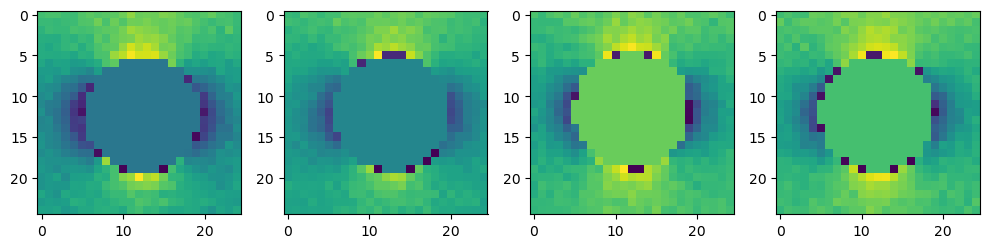

In [11]:
fm_rescaled = rescaling_FOV(fm_sphere, x_sphere, y_sphere, z_sphere)
fm_soap5ml_rescaled = rescaling_FOV(fm_soap5ml, x_sphere_soap5ml, y_sphere_soap5ml, z_sphere_soap5ml)
fm_soap10ml_rescaled = rescaling_FOV(fm_soap10ml, x_sphere_soap10ml, y_sphere_soap10ml, z_sphere_soap10ml)
fm_soap15ml_rescaled = rescaling_FOV(fm_soap15ml, x_sphere_soap15ml, y_sphere_soap15ml, z_sphere_soap15ml)
print(np.shape(fm_rescaled))

plt.figure(figsize=(10,4))
plt.subplot(1,4,1)
plt.imshow(fm_rescaled[:,:,12])
plt.subplot(1,4,2)
plt.imshow(fm_soap5ml_rescaled[:,:,12])
plt.subplot(1,4,3)
plt.imshow(fm_soap10ml_rescaled[:,:,12])
plt.subplot(1,4,4)
plt.imshow(fm_soap15ml_rescaled[:,:,12])
plt.tight_layout()

The susceptibility difference was calculated with two different methods: by comparison to a simulated perfectly spherical ball of higher resolution, and by comparison by a simulation on a mask of the ball with same resolution


# - With rotation of the sphere on Python, and a perfectly spherical ball in the  simu

rotations of 90 degrees

In [12]:
def rotation90clock(A):
    """
    Rotate a 3D array 90 degrees clockwise around the B0 axis. 
    
    Parameters:
    -----------
    A : numpy.ndarray
        A 3D array of shape (m, n, p).
        
    Returns:
    --------
    A_new : numpy.ndarray
        A 3D array of shape (m, p, n) obtained by rotating A 90 degrees clockwise.
        
    """
    m,n,p = np.shape(A)
    A_new=np.zeros((m,p,n))
    for i in range(m):
        for j in range(n):
            for k in range(p):
                A_new[i, k, n-j-1]=A[i,j,k] 
                
    plt.figure(figsize=(7,3))
    plt.subplot(1,2,1)
    plt.imshow(A[:,:,int(p/2)])
    plt.colorbar()
    plt.title("before rotation")
    
    plt.subplot(1,2,2)
    plt.imshow(A_new[:,:,int(p/2)])
    plt.colorbar()
    plt.title('after rotation')
    
    return A_new

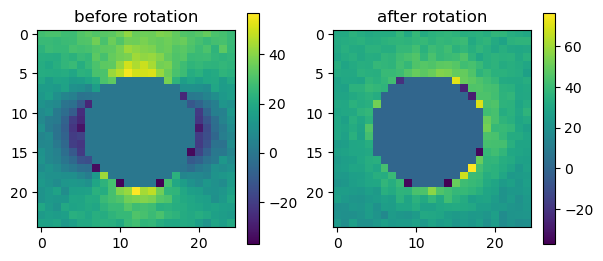

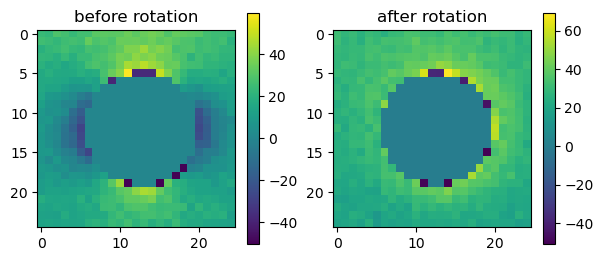

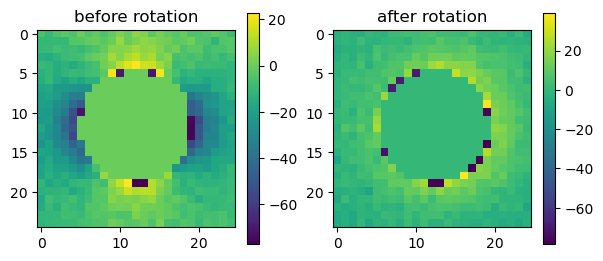

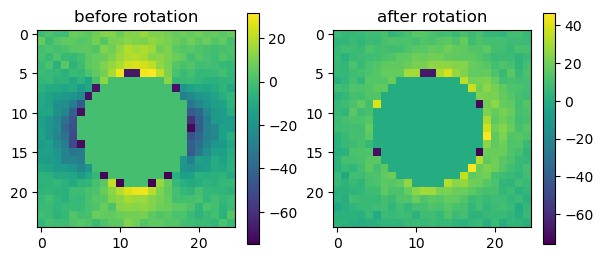

In [13]:
fm_rotated = rotation90clock((fm_rescaled))
fm_soap5ml_rotated = rotation90clock((fm_soap5ml_rescaled))
fm_soap10ml_rotated = rotation90clock((fm_soap10ml_rescaled))
fm_soap15ml_rotated = rotation90clock((fm_soap15ml_rescaled))


## II. Simulations

Downloading the simulation

(300, 300, 300)


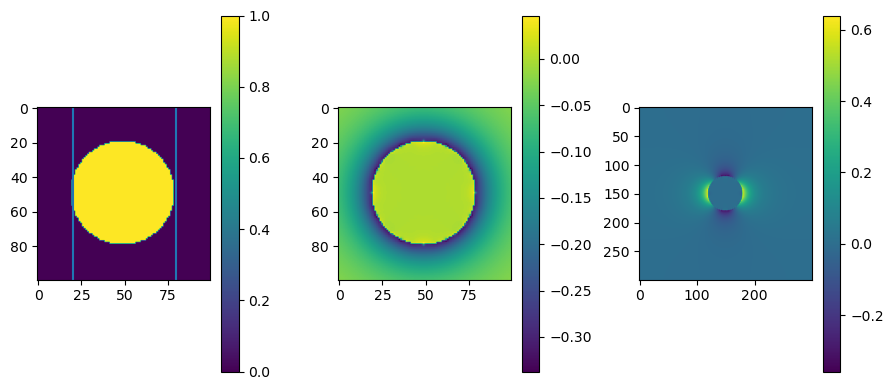

In [14]:
simu = scipy.io.loadmat(r"C:\Users\b\OneDrive\Documents\NTNU\Master's thesis\tests materiaux\220929_test1_materiaux\Sphere_simulation.mat")
sphere_simu = simu['S']
simu_fm = simu['sus_S']
print(np.shape(simu_fm))

plt.figure(figsize=(9,4))
plt.subplot(1,3,1)
plt.imshow(sphere_simu[100:200,100:200,150])
plt.axvline(x=20)
plt.axvline(x=80)

plt.colorbar()

plt.subplot(1,3,2)
plt.imshow((simu_fm[100:200,100:200,150]).real)
plt.colorbar()
plt.tight_layout()

plt.subplot(1,3,3)
# plt.imshow((simu_sla[100:200,150,100:200]).real)
plt.imshow((simu_fm[:,150,:]).real)
plt.colorbar()
plt.tight_layout()


reshaping the simu

(300, 300, 300) (25, 25, 100) (25, 25, 25)


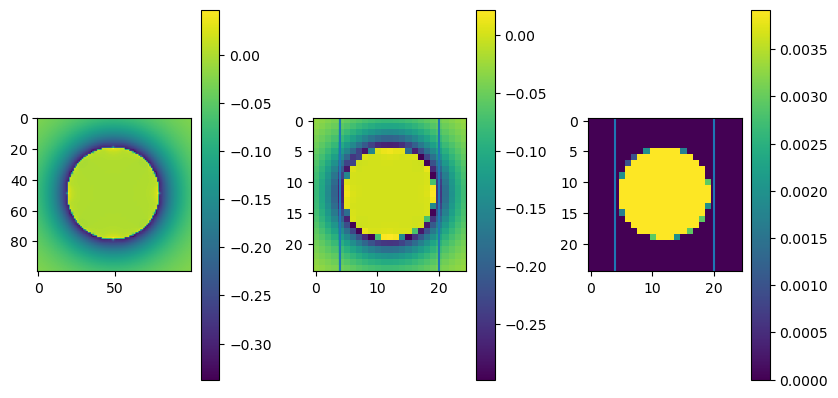

In [15]:
#### the rescale functions works only in 2D so need to do it for every slices
simu_rescaled1 = np.zeros((25,25,100))
simu_rescaled = np.zeros((25,25,25))

sphere_rescaled1= np.zeros((25,25,100))
sphere_rescaled = np.zeros((25,25,25))

for slice in range(100):  #resize on xy directions"
    simu_rescaled1[:,:,slice] = resc(simu_fm[100:200,100:200,slice+100].real, 0.25, anti_aliasing=False)
    sphere_rescaled1[:,:,slice] = resc(sphere_simu[100:200,100:200,slice+100], 0.25, anti_aliasing=False)

for j in range(25): #resize the z direction
    simu_rescaled[:,j, :] = downscale_local_mean(simu_rescaled1[:,j,:], (1, 4))
    sphere_rescaled[:,j, :] = downscale_local_mean(sphere_rescaled1[:,j,:], (1, 4))


plt.figure(figsize=(8,4))
plt.subplot(1,3,1)
plt.imshow(simu_fm[100:200,100:200,150].real)
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(simu_rescaled[:,:,12])
plt.axvline(x=4)
plt.axvline(x=20)
plt.colorbar()
plt.tight_layout()

plt.subplot(1,3,3)
plt.imshow(sphere_rescaled[:,:,12])
plt.colorbar()
plt.axvline(x=4)
plt.axvline(x=20)
print(np.shape(simu_fm), np.shape(simu_rescaled1), np.shape(simu_rescaled))

(25, 25, 25)


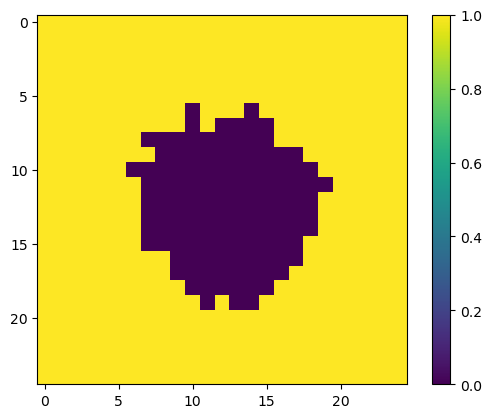

In [22]:
mask_sphere = rescaling_FOV(mask(path_mag1_sphere, 'sphere', tresh=100, plot=False, slice=80), x=x_sphere, y=y_sphere, z=z_sphere)
mask_sphere_soap5ml = rescaling_FOV(mask(path_mag1_sphere_soap5ml, '5ml soap', tresh=500, plot=False, slice=80), x=x_sphere_soap5ml, y=y_sphere_soap5ml, z=z_sphere_soap5ml)
mask_sphere_soap10ml = rescaling_FOV(mask(path_mag1_sphere_soap10ml, '10ml soap', tresh=500, plot=False, slice=80), x=x_sphere_soap10ml, y=y_sphere_soap10ml, z=z_sphere_soap10ml)
mask_sphere_soap15ml = rescaling_FOV(mask(path_mag1_sphere_soap15ml, '15ml soap', tresh=500, plot=False, slice=80), x=x_sphere_soap15ml, y=y_sphere_soap15ml, z=z_sphere_soap15ml)
plt.imshow(mask_sphere[:,:,12])
plt.colorbar()

print(np.shape(mask_sphere))


## III. Linear regression between experiment and simulation


In [23]:
def linear_reg_simexp(fm_simu, fm_exp, masksimu, maskexp, c_soap):
    '''
    Calculate the linear regression between 'fm_simu' and 'fm_exp', excluding the values inside the masks (inside the ball).
    
    Plot the linear regression, and one transversal and one sagittal slices of the simulated and acquired field map.
    
    Parameters
    ----------
    fm_simu : np.ndarray
        3D array of the simulated FM.
    fm_exp : np.ndarray
        3D array of the acquired FM.
    masksimu : np.ndarray
        3D array of the simulated mask.
    maskexp : np.ndarray
        3D array of the acquired mask.
    c_soap : str
        concentration of soap.
    
    Returns
    -------
    result_corrected : scipy.stats._stats_mstats_common.LinregressResult
        A tuple containing the parameters of the regression line.
    
    '''

    ### reshaping to 1D vector
    m,n,p = fm_simu.shape
    simu = fm_simu.reshape(m*n*p) #need to have vector 1D to apply the linear regression
    exp = fm_exp.reshape(n*m*p)



    mask_exp = maskexp.reshape(m*n*p)
    mask_simu = masksimu.reshape(m*n*p)

    exp_corrected = []
    simu_corrected=[]

    for i in range(m*p*n):
        if mask_exp[i] == 1 and mask_simu[i]==0:
            simu_corrected.append(simu[i])
            exp_corrected.append(exp[i])

    ### regression lineaire
    result_corrected = scipy.stats.linregress(simu_corrected, exp_corrected)
    print(f'######## regression linéaire - {c_soap} ############')
    print(f' fm_exp = {result_corrected.slope} * fm_simu + {result_corrected.intercept} ')
    print(f'R^2 = {result_corrected.rvalue **2}')
    print(f'p-value = {result_corrected.pvalue }')


    #######################"" plot################################
    plt.figure()
    plt.plot(simu_corrected, exp_corrected, '.', c='pink', label=c_soap)
    plt.xlabel('Simulation')
    plt.ylabel('Experience')
    plt.title('Correlation between simulation and experience on the whole 3D array')
    plt.plot(simu, result_corrected.intercept + result_corrected.slope*simu, 'b')
    plt.legend()
    plt.show()


    ####################### plot ################################
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 7))
    im5 = axes[0][0].imshow((fm_simu)[:,:, 12])
    axes[0][0].axis('off')
    axes[0][0].set_title('Simulation')

    im4 = axes[1][0].imshow((fm_simu)[:,12,:])
    axes[1][0].axis('off')
    # axes[1][0].set_title('Simulation')

    im = axes[0][1].imshow((fm_exp)[:,:, 12])
    axes[0][1].axis('off')
    axes[0][1].set_title('Experience')

    im3 = axes[1][1].imshow((fm_exp)[:,12,:])
    axes[1][1].axis('off')
    # axes[1][1].set_title('Experience')

    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)

    # add an axes, lower left corner in [0.83, 0.1] measured in figure coordinate with axes width 0.02 and height 0.8
    #cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
    #cbar = fig.colorbar(im, cax=cb_ax)
    plt.show()
    return result_corrected

### A. just water

######## regression linéaire - water ############
 fm_exp = -85.61307942184101 * fm_simu + 22.200955904193087 
R^2 = 0.7015343815237833
p-value = 0.0


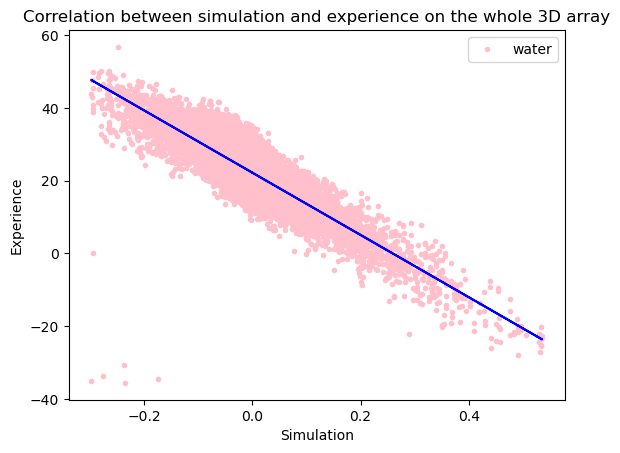

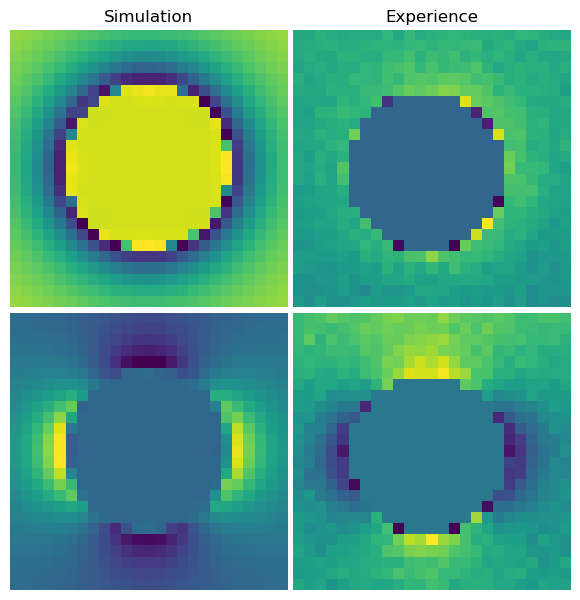

In [24]:
result_water = linear_reg_simexp(fm_simu=simu_rescaled, fm_exp=fm_rotated, masksimu=sphere_rescaled, maskexp=mask_sphere, c_soap='water')


### B. 5ml soap

######## regression linéaire - soap 5ml ############
 fm_exp = -84.66417268000248 * fm_simu + 19.686465382779826 
R^2 = 0.6618100255254663
p-value = 0.0


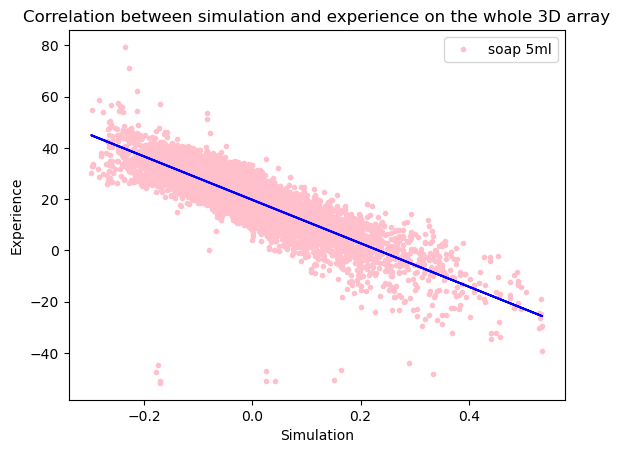

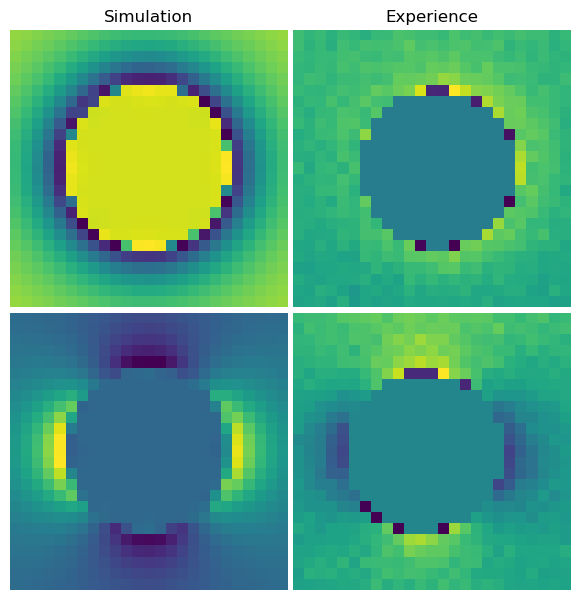

In [25]:
result_soap5ml = linear_reg_simexp(fm_simu=simu_rescaled, fm_exp=fm_soap5ml_rotated, masksimu=sphere_rescaled, maskexp=mask_sphere_soap5ml, c_soap='soap 5ml')


### C. soap 10ml

######## regression linéaire - soap 10ml ############
 fm_exp = -83.1234877328463 * fm_simu + -6.124394270711464 
R^2 = 0.8346264419423908
p-value = 0.0


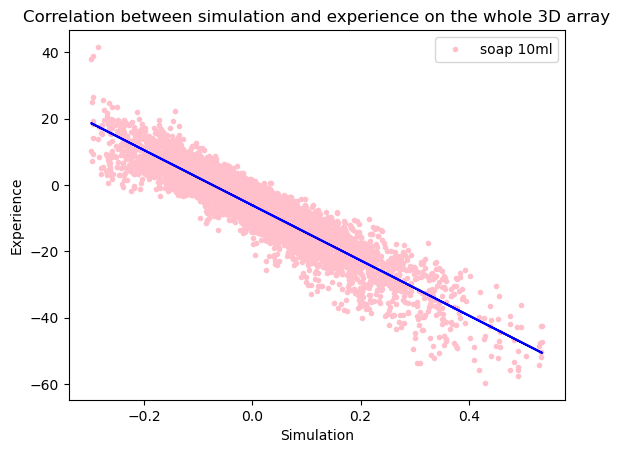

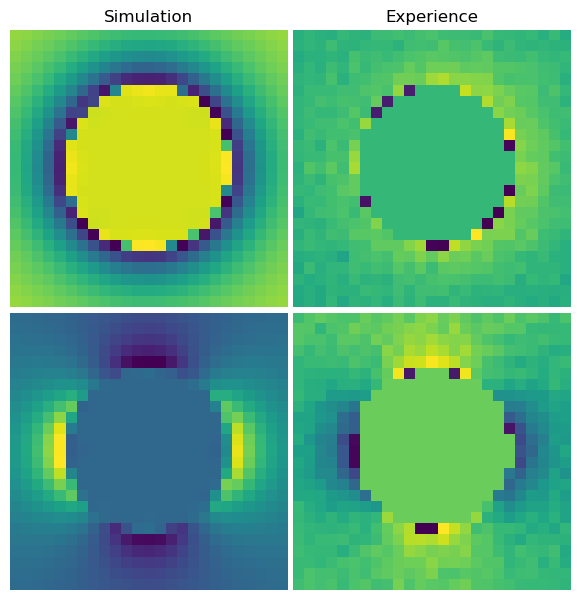

In [26]:
result_soap10ml = linear_reg_simexp(fm_simu=simu_rescaled, fm_exp=fm_soap10ml_rotated, masksimu=sphere_rescaled, maskexp=mask_sphere_soap10ml, c_soap='soap 10ml')


### D. 15ml soap

######## regression linéaire - soap 15ml ############
 fm_exp = -84.36596209961888 * fm_simu + 0.9253085918279037 
R^2 = 0.846775997282369
p-value = 0.0


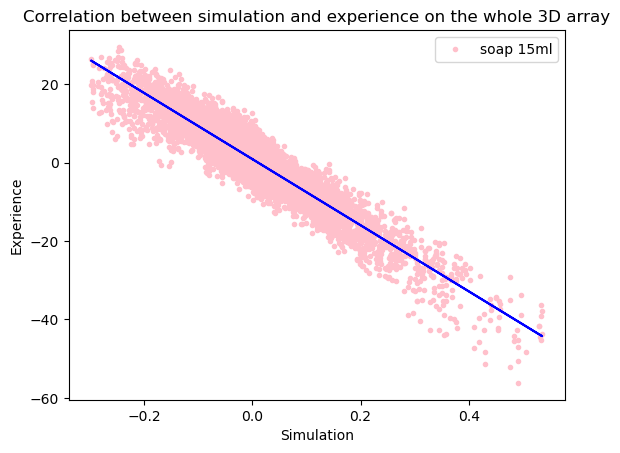

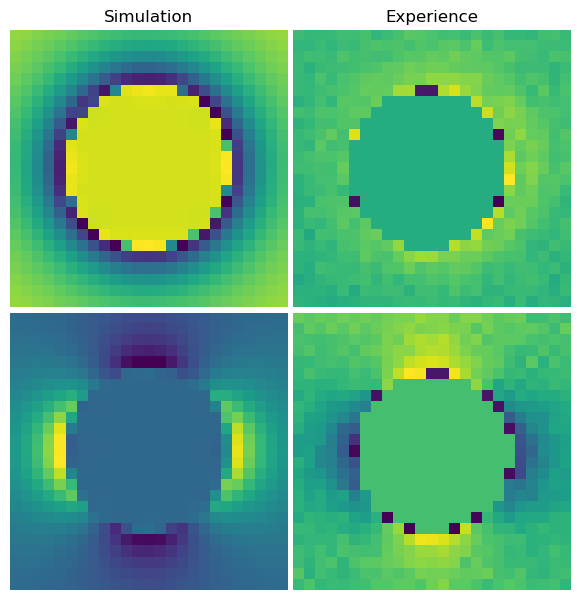

In [27]:
result_soap15ml = linear_reg_simexp(fm_simu=simu_rescaled, fm_exp=fm_soap15ml_rotated, masksimu=sphere_rescaled, maskexp=mask_sphere_soap15ml, c_soap='soap 15ml')


### E. Evolution and summary

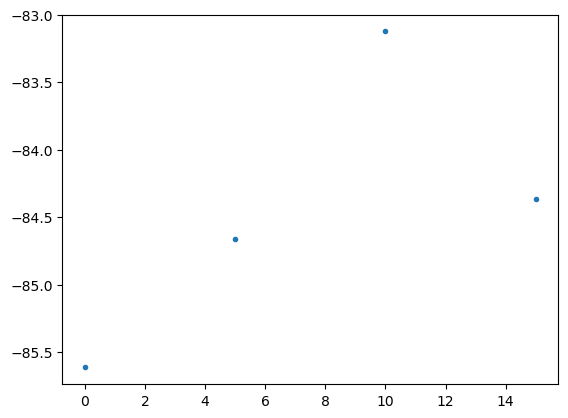

In [28]:
result=np.array([result_water.slope, result_soap5ml.slope, result_soap10ml.slope, result_soap15ml.slope])

plt.figure()
plt.plot([0,5,10,15], result, '.')

In [29]:
fig = go.Figure(data=[go.Table(
    header=dict(values=['soap concentration', 'slope', 'intercept', '$R^2$', 'pvalue'],
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='left'),
    cells=dict(values=[['water', '5ml soap', '10ml soap', '15ml soap'], # 1st column
                       [result_water.slope, result_soap5ml.slope, result_soap10ml.slope, result_soap15ml.slope], 
                       [result_water.intercept, result_soap5ml.intercept, result_soap10ml.intercept, result_soap15ml.intercept],
                      [result_water.rvalue**2, result_soap5ml.rvalue**2, result_soap10ml.rvalue**2, result_soap15ml.rvalue**2],
                      [result_water.pvalue, result_soap5ml.pvalue, result_soap10ml.pvalue, result_soap15ml.pvalue]],
               line_color='darkslategray',
               fill_color='lightcyan',
               align='left'))
])

fig.update_layout(width=1000, height=300)
fig.show()

# --> This time we ran the simu on the experimental masks

Exporting the masks

In [31]:
### save and export the masks in matlab format to run the simulation on them
mdic = {"mask_sphere": mask_sphere, "label": "mask_sphere"}
#savemat("mask_sphere.mat", mdic)
mdic = {"mask_sphere_soap5ml": mask_sphere_soap5ml, "label": "mask_sphere_soap5ml"}
#savemat("mask_sphere_soap5ml.mat", mdic)
mdic = {"mask_sphere_soap10ml": mask_sphere_soap10ml, "label": "mask_sphere_soap10ml"}
#savemat("mask_sphere_soap10ml.mat", mdic)
mdic = {"mask_sphere_soap15ml": mask_sphere_soap15ml, "label": "mask_sphere_soap15ml"}
#savemat("mask_sphere_soap15ml.mat", mdic)

Importing back the simulation run on the mask

In [32]:
simu_fm_sphere = scipy.io.loadmat(r"simu-moi\simu_sphere\fm_sphere.mat")['I_sus'][119:144,119:144,119:144].real
simu_mask_sphere = -(scipy.io.loadmat(r"simu-moi\simu_sphere\mask_sphere.mat")['I'][119:144,119:144,119:144]-1)
simu_fm_sphere_soap5ml = scipy.io.loadmat(r"simu-moi\simu_sphere\fm_sphere_soap5ml.mat")['I_sus'][119:144,119:144,119:144].real
simu_mask_sphere_soap5ml = -(scipy.io.loadmat(r"simu-moi\simu_sphere\mask_sphere_soap5ml.mat")['I'][119:144,119:144,119:144]-1)
simu_fm_sphere_soap10ml = scipy.io.loadmat(r"simu-moi\simu_sphere\fm_sphere_soap10ml.mat")['I_sus'][119:144,119:144,119:144].real
simu_mask_sphere_soap10ml = -(scipy.io.loadmat(r"simu-moi\simu_sphere\mask_sphere_soap10ml.mat")['I'][119:144,119:144,119:144]-1)
simu_fm_sphere_soap15ml = scipy.io.loadmat(r"simu-moi\simu_sphere\fm_sphere_soap15ml.mat")['I_sus'][119:144,119:144,119:144].real
simu_mask_sphere_soap15ml = -(scipy.io.loadmat(r"simu-moi\simu_sphere\mask_sphere_soap15ml.mat")['I'][119:144,119:144,119:144]-1)
print(np.shape(simu_fm_sphere))
print(np.shape(mask_sphere))


(25, 25, 25)
(25, 25, 25)


Check that there is a good superposition

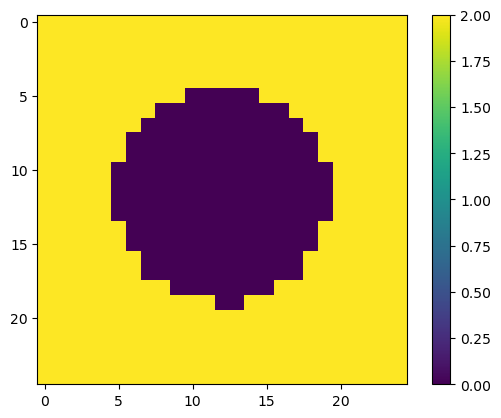

In [33]:
plt.imshow((simu_mask_sphere+mask_sphere)[:,:,5])
#plt.imshow((simu_mask_sphere+mask_sphere)[:,13,:])
plt.imshow((simu_mask_sphere_soap10ml+mask_sphere_soap10ml)[:,:,13])

plt.colorbar()

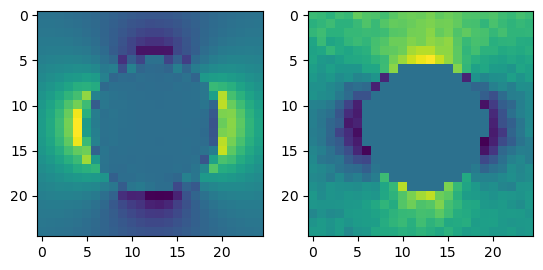

In [34]:
plt.figure()
plt.subplot(121)
plt.imshow(simu_fm_sphere[:,:,13])
plt.subplot(122)
plt.imshow(fm_rescaled[:,:,13])

## Linear regression between exp and simu on the experimental mask

In [35]:
def linear_reg_simexp_expmask(fm_simu, fm_exp, masksimu, maskexp, c_soap):
    '''
    Calculate the linear regression between 'fm_simu' and 'fm_exp', excluding the values inside the masks (inside the ball).
    
    Plot the linear regression, and one transversal and one sagittal slices of the simulated and acquired field map. Identical to linear_reg_simexp
    
    Parameters
    ----------
    fm_simu : np.ndarray
        3D array of the simulated FM.
    fm_exp : np.ndarray
        3D array of the acquired FM.
    masksimu : np.ndarray
        3D array of the simulated mask.
    maskexp : np.ndarray
        3D array of the acquired mask.
    c_soap : str
        concentration of soap.
    
    Returns
    -------
    result_corrected : scipy.stats._stats_mstats_common.LinregressResult
        A tuple containing the parameters of the regression line.
    
    '''
    ### reshaping to 1D vector
    m,n,p = fm_simu.shape
    simu = fm_simu.reshape(m*n*p) #need to have vector 1D to apply the linear regression
    exp = fm_exp.reshape(n*m*p)



    mask_exp = maskexp.reshape(m*n*p)
    mask_simu = masksimu.reshape(m*n*p)

    exp_corrected = []
    simu_corrected=[]

    for i in range(m*p*n):
        if mask_exp[i] == 1 and mask_simu[i]==1:
            simu_corrected.append(simu[i])
            exp_corrected.append(exp[i])

    ### regression lineaire
    result_corrected = scipy.stats.linregress(simu_corrected, exp_corrected)
    print(f'######## regression linéaire - {c_soap} ############')
    print(f' fm_exp = {result_corrected.slope} * fm_simu + {result_corrected.intercept} ')
    print(f'R^2 = {result_corrected.rvalue **2}')
    print(f'p-value = {result_corrected.pvalue }')


    #######################"" plot################################
    plt.figure()
    plt.plot(simu_corrected, exp_corrected, '.', c='pink', label=c_soap)
    plt.xlabel('Simulation')
    plt.ylabel('Experience')
    plt.title('Correlation between simulation and experience on the whole 3D array')
    plt.plot(simu, result_corrected.intercept + result_corrected.slope*simu, 'b')
    plt.legend()
    plt.show()


    ####################### plot ################################
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 7))
    im5 = axes[0][0].imshow((fm_simu)[:,:, 12])
    axes[0][0].axis('off')
    axes[0][0].set_title('Simulation')

    im4 = axes[1][0].imshow((fm_simu)[:,12,:])
    axes[1][0].axis('off')
    # axes[1][0].set_title('Simulation')

    im = axes[0][1].imshow((fm_exp)[:,:, 12])
    axes[0][1].axis('off')
    axes[0][1].set_title('Experience')

    im3 = axes[1][1].imshow((fm_exp)[:,12,:])
    axes[1][1].axis('off')
    # axes[1][1].set_title('Experience')

    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)

    # add an axes, lower left corner in [0.83, 0.1] measured in figure coordinate with axes width 0.02 and height 0.8
    #cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
    #cbar = fig.colorbar(im, cax=cb_ax)
    plt.show()
    return result_corrected

######## regression linéaire - water ############
 fm_exp = -80.6791720872006 * fm_simu + 22.247812073134934 
R^2 = 0.7056591088432039
p-value = 0.0


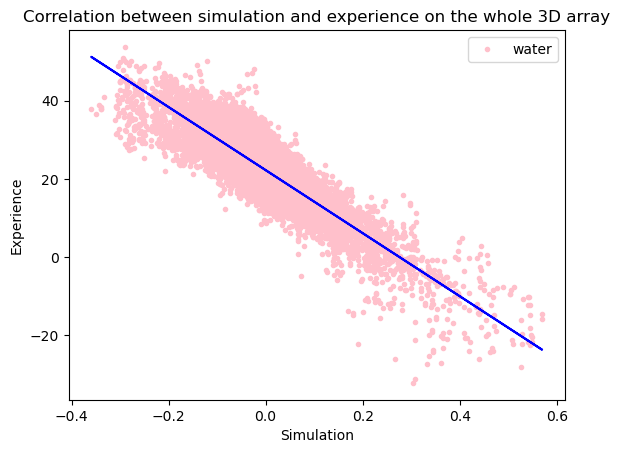

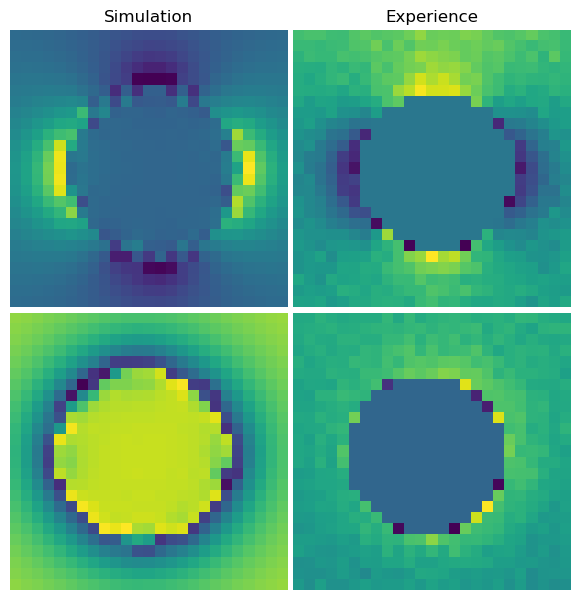

In [36]:
result_water_simumask = linear_reg_simexp_expmask(fm_simu=simu_fm_sphere, fm_exp=fm_rescaled, masksimu=simu_mask_sphere, maskexp=mask_sphere, c_soap='water')


######## regression linéaire - 5ml soap ############
 fm_exp = -92.82540146479519 * fm_simu + 19.65018261276888 
R^2 = 0.7437903572847545
p-value = 0.0


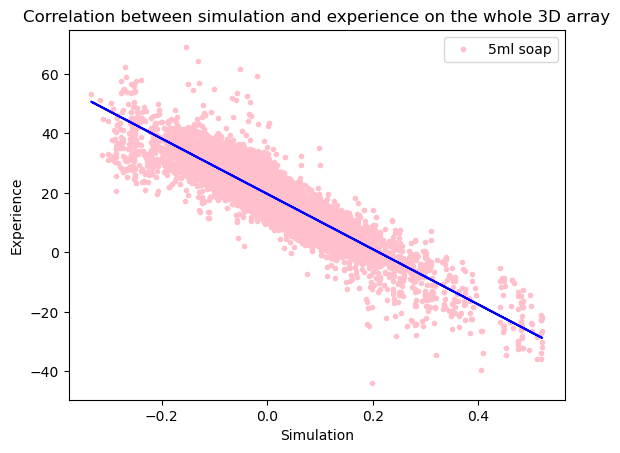

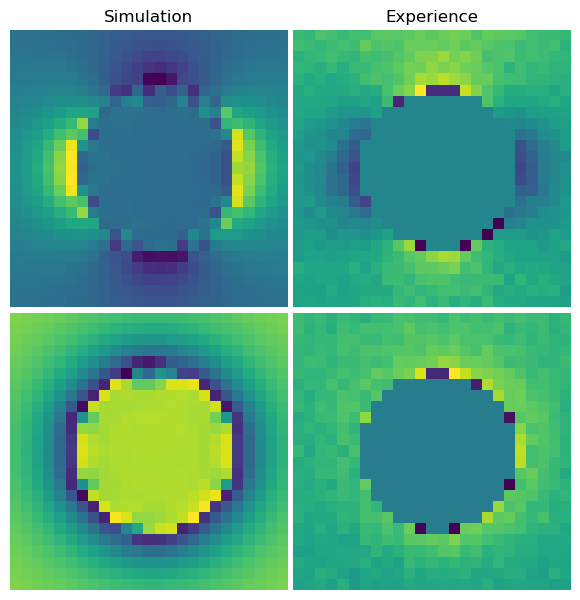

In [37]:
result_soap5ml_simumask = linear_reg_simexp_expmask(fm_simu=simu_fm_sphere_soap5ml, fm_exp=fm_soap5ml_rescaled, masksimu=simu_mask_sphere_soap5ml, maskexp=mask_sphere_soap5ml, c_soap='5ml soap')


######## regression linéaire - 10ml soap ############
 fm_exp = -89.93007235166533 * fm_simu + -6.167077006924851 
R^2 = 0.8435999701674083
p-value = 0.0


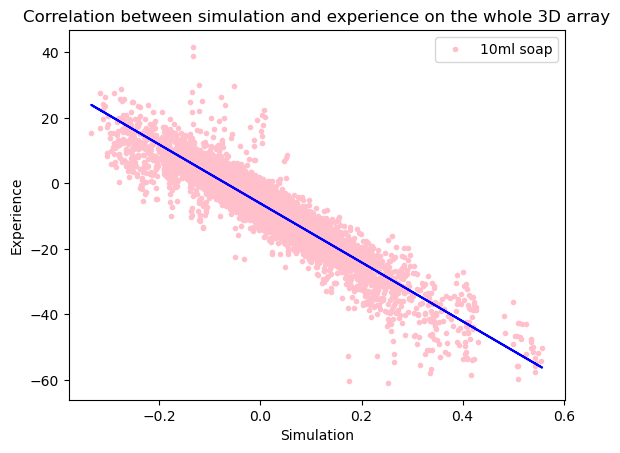

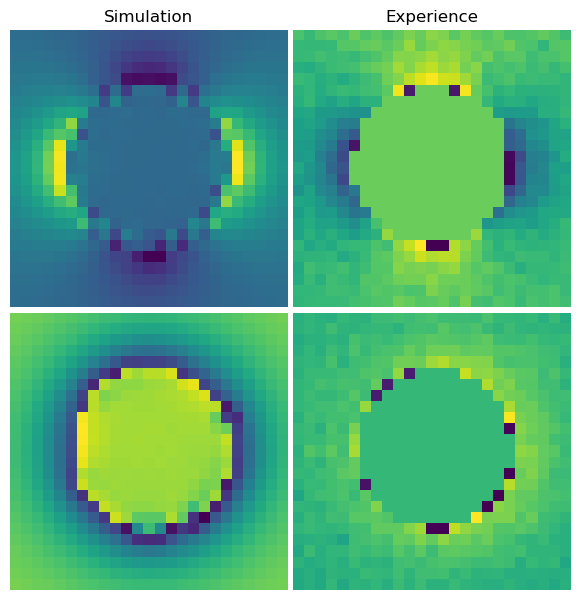

In [38]:
result_soap10ml_simumask = linear_reg_simexp_expmask(fm_simu=simu_fm_sphere_soap10ml, fm_exp=fm_soap10ml_rescaled, masksimu=simu_mask_sphere_soap10ml, maskexp=mask_sphere_soap10ml, c_soap='10ml soap')


######## regression linéaire - 15ml soap ############
 fm_exp = -91.299093729353 * fm_simu + 0.9249336622438697 
R^2 = 0.8223735645887692
p-value = 0.0


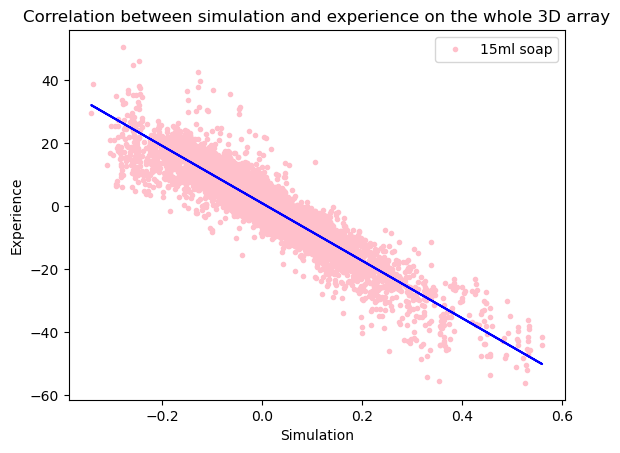

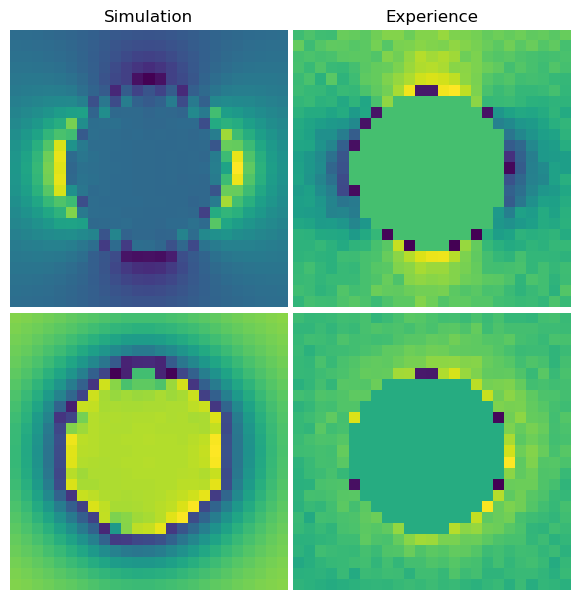

In [39]:
result_soap15ml_simumask = linear_reg_simexp_expmask(fm_simu=simu_fm_sphere_soap15ml, fm_exp=fm_soap15ml_rescaled, masksimu=simu_mask_sphere_soap15ml, maskexp=mask_sphere_soap15ml, c_soap='15ml soap')


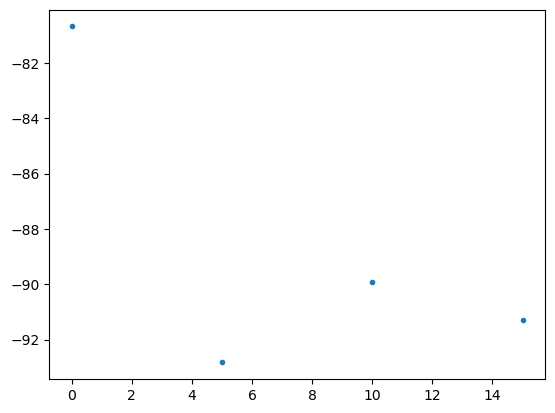

In [40]:
result=np.array([result_water_simumask.slope, result_soap5ml_simumask.slope, result_soap10ml_simumask.slope, result_soap15ml_simumask.slope])

plt.figure()
plt.plot([0,5,10,15], result, '.')

In [41]:
fig = go.Figure(data=[go.Table(
    header=dict(values=['soap concentration', 'slope', 'intercept', '$R^2$', 'pvalue'],
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='left'),
    cells=dict(values=[['water', '5ml soap', '10ml soap', '15ml soap'], # 1st column
                       [result_water_simumask.slope, result_soap5ml_simumask.slope, result_soap10ml_simumask.slope, result_soap15ml_simumask.slope], 
                       [result_water_simumask.intercept, result_soap5ml_simumask.intercept, result_soap10ml_simumask.intercept, result_soap15ml_simumask.intercept],
                      [result_water_simumask.rvalue**2, result_soap5ml_simumask.rvalue**2, result_soap10ml_simumask.rvalue**2, result_soap15ml_simumask.rvalue**2],
                      [result_water_simumask.pvalue, result_soap5ml_simumask.pvalue, result_soap10ml_simumask.pvalue, result_soap15ml_simumask.pvalue]],
               line_color='darkslategray',
               fill_color='lightcyan',
               align='left'))
])

fig.update_layout(width=1000, height=300)
fig.show()